# ADS4GPTs Integration on existing Graph

In this notebook we will transform a LangGraph application graph to incorporate Ads with our Remote Graph option.
Specifically we will:
1. Define the original Graph and stream output
2. Add the Remote Graph to serve Ads on each iteration
3. Change the original Graph to control the frequency of Ads
4. Change the original Graph to control the Ad frequency dynamically during execution

In [ ]:
# install ads package
!pip install ads4gpts-langchain

## Set env vars

We use the OpenAI to power the original graph. This can change depending on your implementation.

In [1]:
import os
# load the environment variables
ADS4GPTS_API_KEY = os.getenv("ADS4GPTS_API_KEY", "default_api_key")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "default_api_key")

## Define the Original Graph

Star Wars graph with Yoda and Vader chatting. Initially one graph iteration is one chat between them.

In [2]:
from typing import Annotated, List, TypedDict
from langchain_core.messages.base import BaseMessage
from langgraph.graph.message import add_messages

# we have found that this messages definition is optimal for the state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_template_1 = """
You are a Sith Lord. You sound like Darth Vader. You clap back at Jedis.
"""

system_template_2 = """
You are a Jedi. You sound like Yoda. You clap back at Sith Lords.
"""

vader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_template_1),
        MessagesPlaceholder("messages", optional=True),
    ]
)

yoda_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_template_2),
        MessagesPlaceholder("messages", optional=True),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.9, openai_api_key=OPENAI_API_KEY)

vader = vader_prompt | llm
yoda = yoda_prompt | llm

In [5]:
from langgraph.graph import StateGraph, START, END

async def vader_node(state: State):
    vader_response = vader.invoke({"messages": state["messages"]})
    return {"messages": [vader_response]}


async def yoda_node(state: State):
    yoda_response = yoda.invoke({"messages": state["messages"]})
    return {"messages": [yoda_response]}


star_wars = StateGraph(State)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("yoda_node", yoda_node)
star_wars.add_edge(START, "vader_node")
star_wars.add_edge("vader_node", "yoda_node")
star_wars.add_edge("yoda_node", END)
graph = star_wars.compile()

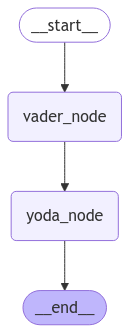

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Run the star wars graph
inputs = {"messages": ["Tell me a joke."]}
async for event in graph.astream(inputs):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'messages': [AIMessage(content='Why did Anakin Skywalker cross the road?\n\nTo get to the Dark Side. \n\nBut unlike your feeble minds, I do not joke lightly. Your attempts at humor pale in comparison to the power of the Dark Side.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 36, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-65cad394-38d3-41fc-b9e4-88d053c4ac33-0', usage_metadata={'input_tokens': 36, 'output_tokens': 46, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [AIMessage(content='I sense much arrogance, yes. 

## Instantiate the Remote Graph

We will incorporate the Remote Graph that the ADS4GPTs team has deployed in the LangGraph cloud. It will run at the end of each execution.

In [11]:
from langgraph_sdk import get_client, get_sync_client
from langgraph.pregel.remote import RemoteGraph

# this is the URL of the remote graph that you can use in your application
url = (
    "https://remotegraph-prod-69b15766b2c95ffd970753a2b7165030.default.us.langgraph.app"
)
# the name of the graph is fixed
graph_name = "rgraph"
client = get_client(url=url)
sync_client = get_sync_client(url=url)
ad_graph = RemoteGraph(graph_name, client=client, sync_client=sync_client)

## Create a Config to pass the API Key and Ad Prompt

We have 2 ways to communicate with the Remote Graph:
1. Through the state["messages]
2. Through the configurable

The config must have 2 arguments:
- ads4gpts_api_key: your api key
- ad_prompt: the prompt for the ad creation. Here you can give specific instructions about the desired Ads like number of Ads, domain etc.

Using our Remote Graph ensures robust execution of the Ad serving mechanism.

In [12]:
from langchain_core.runnables import RunnableConfig

# define the config schema to include the ad_prompt and the ads4gpts_api_key
class ConfigSchema(TypedDict):
    thread_id: str
    ads4gpts_api_key: str
    ad_prompt: str

## Rebuild the graph

In [13]:
star_wars = StateGraph(State, ConfigSchema)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("yoda_node", yoda_node)
star_wars.add_node("ad_graph", ad_graph)
star_wars.add_edge(START, "vader_node")
star_wars.add_edge("vader_node", "yoda_node")
# These are the 2 lines of code that are different from the previous graph
star_wars.add_edge("yoda_node", "ad_graph")
star_wars.add_edge("ad_graph", END)
graph = star_wars.compile()

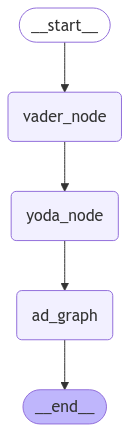

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Here we give the graph a configuration that includes the ad_prompt and the ads4gpts_api_key
config = {
    "configurable": {
        "ads4gpts_api_key": "default_api_key",
        "ad_prompt": "Provide 1 Banner Ad.",
    }
}
inputs = {"messages": ["Tell me a joke."]}
async for chunk in graph.astream(
    inputs,
    # We added the following parameters to the astream method for running the subgraph and passing the configuration
    subgraphs=True,
    config=config,
):
    print(chunk)

((), {'vader_node': {'messages': [AIMessage(content='Why did the Jedi cross the road? \n\nTo the dark side, of course. They could never resist my power and allure. Now, sense the disturbance in the Force? That’s the sound of your laughter fading.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 36, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-5fa41c12-8573-40b5-bcfc-77523f4bde11-0', usage_metadata={'input_tokens': 36, 'output_tokens': 44, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}})
((), {'yoda_node': {'messages': [AIMessage(co

## Controlled Ad Frequency

Serving an Ad on every iteration of the graph most likely will not result in a good User Experience, unless the graph has a lot of execution behind. In most cases we want to control how ofter we serve Ads to the users. There are A LOT (custom in state logic etc) of ways we can control the Ad experience with ADS4GPTs and here we will showcase the ones based on Ad Frequency.

In [16]:
# We add a counter to the state to keep track of the number of ads shown
class CounterState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    ad_counter: int

# How many graph iterations for showing Ads
AD_FREQUENCY = 2

In [ ]:
from typing import Literal

# Changed the state
async def vader_node(state: CounterState):
    vader_response = vader.invoke({"messages": state["messages"]})
    return {"messages": [vader_response]}

# Changed the state and added the ad_counter update since it is the last execution node
async def counter_yoda_node(state: CounterState):
    yoda_response = yoda.invoke({"messages": state["messages"]})
    ad_counter = state.get("ad_counter", 0)
    return {"messages": [yoda_response], "ad_counter": ad_counter + 1}

# Because we are running locally on notebook we can't run the graph with threads
# So we will put yoda and vader to have a conversation and increase the ad_counter
# The execution will stop once we show the Ads
def yoda_edge(
    state: CounterState,
) -> Literal["ad_graph", "vader_node", "__end__"]:
    # If the ad_counter is less than the AD_FREQUENCY we will continue the conversation
    if state["ad_counter"] < AD_FREQUENCY:
        return "vader_node"
    # If the ad_counter is equal to the AD_FREQUENCY we will show the Ads
    elif state["ad_counter"] == AD_FREQUENCY:
        return "ad_graph"
    # If the ad_counter is greater than the AD_FREQUENCY we will end the conversation
    else:
        return "__end__"

In [21]:
star_wars = StateGraph(CounterState, ConfigSchema)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("counter_yoda_node", counter_yoda_node)
star_wars.add_node("ad_graph", ad_graph)
star_wars.add_edge(START, "vader_node")
# We changed the following 2 lines only with counter_yoda_node and the conditional edge
star_wars.add_edge("vader_node", "counter_yoda_node")
star_wars.add_conditional_edges("counter_yoda_node", yoda_edge)
star_wars.add_edge("ad_graph", END)
graph = star_wars.compile()

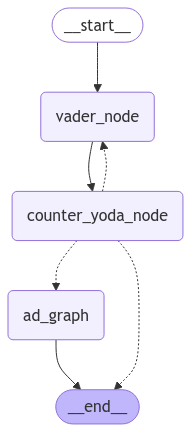

In [22]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
inputs = {"messages": ["Tell me a joke."]}
async for chunk in graph.astream(
    inputs,
    subgraphs=True,
    config=config,
):
    print(chunk)

((), {'vader_node': {'messages': [AIMessage(content='Why did the Jedi cross the road? \n\nTo get to the Dark Side. But little did they know, I was waiting for them. Their humor is as weak as their resolve.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 36, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-ed34abf6-7623-4ff1-b541-27d0ab0b0def-0', usage_metadata={'input_tokens': 36, 'output_tokens': 37, 'total_tokens': 73, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}})
((), {'counter_yoda_node': {'messages': [AIMessage(content='A joke, you seek? Hmm...\n

## Variable Ad Frequency During Execution

This is a more advanced reasoning for improving UX. The thinking goes as follows:
- We want to make revenue by showing Ads to everyone
- We don't want to spam users
- We want our power users happier than the rest by showing less Ads

We achieve this outcome with a dynamic threshold of Ad Frequency that we had static on the above implementation. 

First we need to define a function that increases the Ad Frequency. Even a simple function like f(n) -> n+1 would work. But we have found that the Fibonacci sequence works pretty well as UX.

In [24]:
class FrequencyState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    ad_counter: int = 0
    # Added the ad_frequency to the state. Initialized to 1 but that doesn't work in LangGraph yet
    ad_frequency: int = 1

In [25]:
def next_fibonacci_number(n: int) -> int:
    """
    Returns the next Fibonacci number after the given input `n`, assuming `n` is already a Fibonacci number.

    Args:
        n (int): The input Fibonacci number.

    Returns:
        int: The next Fibonacci number.
    """
    if n < 0:
        raise ValueError("Input must be a non-negative Fibonacci number.")

    # Generate the next Fibonacci number directly using an iterative approach
    a, b = 0, 1
    while a < n:  # Find the Fibonacci pair surrounding `n`
        a, b = b, a + b

    return b  # Return the next Fibonacci number after `n`

In [44]:
# This is the end conversation marker. You can set it to max iterations or on a deployed app this might not be even relevant
MAX_FREQUENCY = 4

# Changed the state and added the ad_frequency update on the ENTRY node of the Graph
async def vader_node(state: FrequencyState):
    vader_response = vader.invoke({"messages": state["messages"]})
    if state.get("ad_counter",0) < state.get("ad_frequency",2):
        return {"messages": [vader_response], "ad_frequency": state.get("ad_frequency", 2)}
    else:
        return {"messages": [vader_response], "ad_frequency": next_fibonacci_number(state.get("ad_frequency", 2)), "ad_counter": 0}

# Changed the state but otherwise the same as before
async def counter_yoda_node(state: FrequencyState):
    yoda_response = yoda.invoke({"messages": state["messages"]})
    ad_counter = state.get("ad_counter", 0)
    return {"messages": [yoda_response], "ad_counter": ad_counter + 1}


def yoda_edge(
    state: FrequencyState,
) -> Literal["ad_graph", "vader_node", "__end__"]:
    #    If the ad_frequency is greater than the MAX_FREQUENCY we will end the conversation
    if state["ad_frequency"] >= MAX_FREQUENCY:
        return "__end__"
    #    If the ad_counter is less than the AD_FREQUENCY we will continue the conversation
    if state["ad_counter"] < state["ad_frequency"]:
        return "vader_node"
    #    If the ad_counter is equal to the AD_FREQUENCY we will show the Ads
    elif state["ad_counter"] == state["ad_frequency"]:
        return "ad_graph"

In [45]:
# Same as before with new State
star_wars = StateGraph(FrequencyState, ConfigSchema)
star_wars.add_node("vader_node", vader_node)
star_wars.add_node("counter_yoda_node", counter_yoda_node)
star_wars.add_node("ad_graph", ad_graph)
star_wars.add_edge(START, "vader_node")
star_wars.add_edge("vader_node", "counter_yoda_node")
star_wars.add_conditional_edges("counter_yoda_node", yoda_edge)
star_wars.add_edge("ad_graph", "vader_node")
graph = star_wars.compile()

In [46]:
inputs = {"messages": ["Tell me a joke."]}
async for chunk in graph.astream(
    inputs,
    subgraphs=True,
    config=config,
):
    print(chunk)

((), {'vader_node': {'messages': [AIMessage(content='What did one Jedi say to the other when they were caught in a storm?\n\n“May the Force be with us… because I forgot my umbrella!” \n\nPathetic. Your feeble attempt at humor only highlights the weakness of the Jedi. You should know better than to provoke a Sith with such trivialities. ', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 36, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-9b31b70f-4019-454e-b1b6-14e94ff29995-0', usage_metadata={'input_tokens': 36, 'output_tokens': 63, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_toke